# B. Exploratory Data Analysis

# 1. Content

# 2. Introduction 

## 2.1 Questions to answer 

- Is location a key consideration for rent?
- Does quantity supplied affect the price of rent?
- Does the size of the state affect rent?
- Do macro economic factors such as population and regional GDP affect rent?
- Did rent increase over the three years that the data set was collected?
- Is rent stable in certain states versus others?
- Which of the advertized features in the data set affect rent?

# 3. Imports 

In [1]:
import pandas as pd
from datetime import datetime
from datetime import date
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from fuzzywuzzy import fuzz

C:\Users\zebin\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 4. Load Data 

## 4.1 Rentals data 

In [2]:
#Load rentals and view data
rentals = pd.read_csv('..\data\processed\\rentals_cleaned.csv')

In [3]:
rentals_eda = rentals.copy()

In [4]:
rentals_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266220 entries, 0 to 266219
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               266220 non-null  object 
 1   serviceCharge       259490 non-null  float64
 2   heatingType         221782 non-null  object 
 3   telekomTvOffer      233938 non-null  object 
 4   newlyConst          266220 non-null  bool   
 5   balcony             266220 non-null  bool   
 6   telekomUploadSpeed  233208 non-null  float64
 7   yearConstructed     209427 non-null  object 
 8   firingTypes         209806 non-null  object 
 9   hasKitchen          266220 non-null  bool   
 10  cellar              266220 non-null  bool   
 11  rent                266220 non-null  float64
 12  livingSpace         266220 non-null  float64
 13  condition           198023 non-null  object 
 14  interiorQual        154634 non-null  object 
 15  petsAllowed         152725 non-nul

In [5]:
rentals_eda.head()

,state,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,telekomUploadSpeed,yearConstructed,firingTypes,hasKitchen,...,interiorQual,petsAllowed,lift,typeOfFlat,noRooms,thermalChar,numberOfFloors,garden,date,rent_per_sqm
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,False,False,10.0,1965-01-01,oil,False,...,normal,NaN,False,ground_floor,4.0,181.4,3.0,True,2019-05-01,6.918605
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,False,True,10.0,1871-01-01,gas,False,...,normal,no,False,ground_floor,3.0,NaN,NaN,False,2019-05-01,8.988764
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,True,True,2.4,2019-01-01,NaN,False,...,sophisticated,NaN,True,apartment,3.0,NaN,4.0,False,2019-10-01,11.515513
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,False,True,40.0,1964-01-01,district_heating,False,...,NaN,NaN,False,other,3.0,86.0,NaN,False,2019-05-01,5.898538
4,Bremen,138.00,self_contained_central_heating,NaN,False,True,NaN,1950-01-01,gas,False,...,NaN,NaN,False,apartment,3.0,188.9,NaN,False,2020-02-01,9.003178


## 4.2 State-wide geo-economic data 

In [6]:
# Load and view geo-economic data
geo_economy = pd.read_csv('..\data\processed\\state_features.csv')

In [7]:
geo_economy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                16 non-null     object 
 1   area_km2             16 non-null     int64  
 2   population_2019      16 non-null     int64  
 3   population_per_km2   16 non-null     int64  
 4   gdp_per_capita_2018  16 non-null     int64  
 5   hdi                  16 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 896.0+ bytes


In [8]:
geo_economy.head()

,state,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi
0,Baden-Württemberg,35752,11100394,310,47290,0.953
1,Bavaria(Bayern),70552,13124737,185,48323,0.947
2,Berlin,892,3669491,4086,41967,0.950
3,Brandenburg,29479,2521893,85,29541,0.914
4,Bremen,419,681202,1630,49215,0.951


# 5. Explore Data 

## 5.1 Relationship between rent and location

### 5.1.1 State-wise review of rent

In [9]:
#Rename name baseRent column of rentals_eda dataframe to rent
rentals_eda.columns

Index(['state', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'newlyConst',
       'balcony', 'telekomUploadSpeed', 'yearConstructed', 'firingTypes',
       'hasKitchen', 'cellar', 'rent', 'livingSpace', 'condition',
       'interiorQual', 'petsAllowed', 'lift', 'typeOfFlat', 'noRooms',
       'thermalChar', 'numberOfFloors', 'garden', 'date', 'rent_per_sqm'],
      dtype='object')

In [10]:
#Create a dataframe with state as index and mean / median rent
avg_state_rent = rentals_eda.groupby('state').agg(median_rent = pd.NamedAgg(column = 'rent', aggfunc = 'median'), \
                                mean_rent = pd.NamedAgg(column = 'rent', aggfunc = 'mean'))
avg_state_rent.head()

,median_rent,mean_rent
state,,
Baden_Württemberg,850.00,954.974426
Bayern,850.00,1018.459946
Berlin,949.00,1168.719762
Brandenburg,395.00,511.379350
Bremen,502.34,624.148082


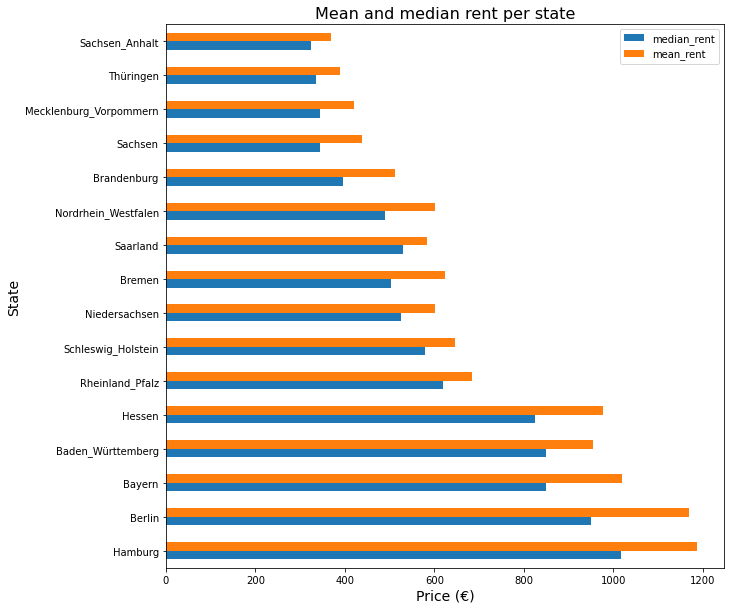

In [11]:
# Create bar plot showing mean and median rent for each state
avg_state_rent.reindex(index= avg_state_rent.mean(axis= 1).sort_values(ascending= False).index).plot(kind= 'barh', figsize= (10, 10))
plt.xlabel('Price (€)', fontsize = 14)
plt.ylabel('State', fontsize = 14)
plt.title('Mean and median rent per state', fontsize = 16);

- We note that location appears to have an impact on the mean and median prices of rent. Sachsen_Anhalt offers the lowest rent, while Hamburg offers the hightest rent. 

In [12]:
#Create dataframe with state and rent
state_rent = rentals_eda[['state', 'rent']]
state_rent.head()

,state,rent
0,Nordrhein_Westfalen,595.0
1,Rheinland_Pfalz,800.0
2,Sachsen,965.0
3,Sachsen,343.0
4,Bremen,765.0


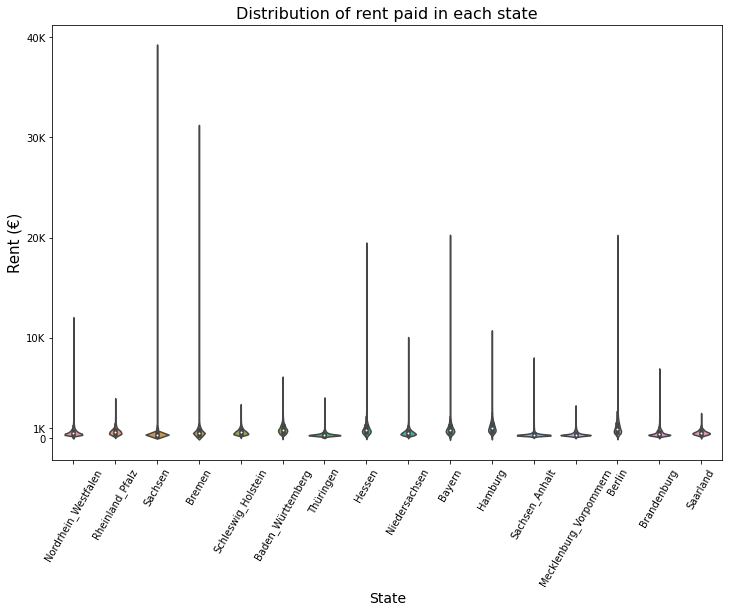

In [13]:
#Create violinplot that shows the range and distribution of rent per state
plt.subplots(figsize=(12, 8))
sns.violinplot(x= 'state', y= 'rent', data= state_rent)
plt.title('Distribution of rent paid in each state', fontsize = 16)
plt.xlabel('State', fontsize = 14)
plt.ylabel('Rent (€)', fontsize = 15)
plt.xticks(rotation= 60)
plt.yticks([0, 1000, 10_000, 20_000, 30_000, 40_000], ['0', '1K', '10K', '20K', '30K', '40K']);


- We note that Sachsen appears to have the widest price range. 
- We also note prices are generally clustered around the median price for most of the states, except Berlin, Hamburg, Bayern, Hessen and Baden Wurttemberg that have a bit more variation in prices. 
- Lastly, we note that Sachsen Anhalt seems to have most of its prices located around its median, with less variation than other states. 

## 5.1.2 One-way ANOVA on state means 

- We will determine if the change in means from one state to another is as a result of natural variation.
- $H_{0}$: $μ_{1}$ = $μ_{2}$ = ... = $μ_{r}$
- $H_{1}$: two or more means are different from the others
- We will test the hypothesis at the p = 0.05 significant level

In [14]:
#Fit a linear regression model that explores the relationship between state and rent
model = ols('rent ~ state', data = state_rent).fit()
anova_table = sm.stats.anova_lm(model,  type = 2)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
state,15.0,1.552111e+10,1.034741e+09,4954.52551,0.0
Residual,266204.0,5.559606e+10,2.088476e+05,NaN,NaN


- Our F-statistic of 4944 suggests that the ratio of our mean square error between states and within states is quite large. We also note that that this leads to p value of practically zero.

- We therefore establish that location on a state-wide level strongly influences rent.

# 5.2 Relationship between quantity supplied and rent 

In [15]:
'''Create a dataframe that show the total number of listings, the total square meters of available space 
and mean and median rent for each state'''
state_supply = rentals_eda.groupby(['state']).agg(total_state_listings = pd.NamedAgg(column = 'rent', aggfunc = 'size'), \
                                               total_state_sqm = pd.NamedAgg(column = 'livingSpace', aggfunc = 'sum'), \
                                                 mean_rent = pd.NamedAgg(column = 'rent', aggfunc = 'mean'), \
                                                 median_rent = pd.NamedAgg(column = 'rent', aggfunc = 'median'))
state_supply

,total_state_listings,total_state_sqm,mean_rent,median_rent
state,,,,
Baden_Württemberg,15961,1342806.70,954.974426,850.000
Bayern,21490,1718920.03,1018.459946,850.000
Berlin,10271,842022.42,1168.719762,949.000
Brandenburg,6875,474904.52,511.379350,395.000
Bremen,2940,213666.12,624.148082,502.340
Hamburg,3730,312253.87,1187.299110,1016.625
Hessen,17682,1466268.24,976.958416,825.000
Mecklenburg_Vorpommern,6580,416557.76,420.522375,345.000
Niedersachsen,16404,1261969.68,601.613710,525.000


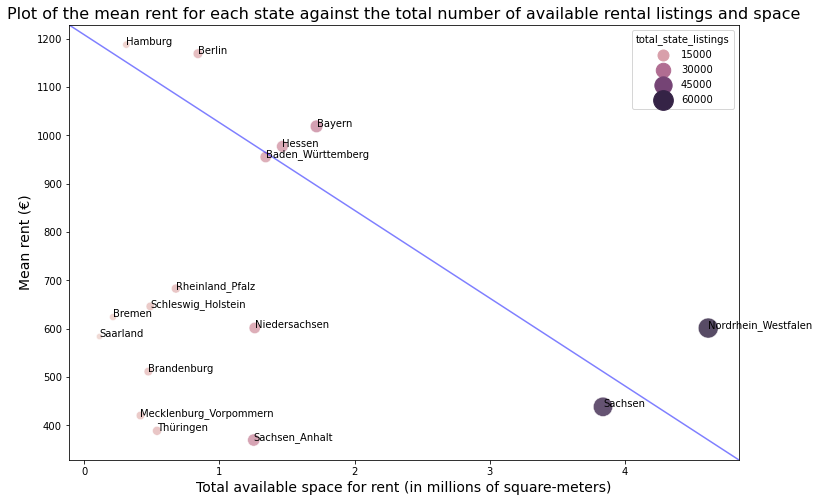

In [16]:
#Plat mean rent against the total number of listings and total square meters of space for each state
x = state_supply.total_state_sqm
y = state_supply.mean_rent
state = state_supply.index
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x = 'total_state_sqm', y = 'mean_rent', data= state_supply, \
                size = 'total_state_listings', hue = 'total_state_listings', sizes=(40, 400), alpha = 0.8)
plt.title('Plot of the mean rent for each state against the total number of available rental listings and space', \
         fontsize = 16)
plt.xlabel('Total available space for rent (in millions of square-meters)', fontsize = 14)
plt.ylabel('Mean rent (€)', fontsize = 14)
plt.xticks([0, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000],['0', '1', '2', '3', '4', '5'] )
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))
ax.plot([1, 0], [0, 1], transform=ax.transAxes, alpha = 0.5, c = 'blue');

- We note a pattern emerging for three state clusters, where rent increases with limited supply in both the number of listings and space available. These clusters in order of higher rent and lower supply include:
    - Hamburg and Berlin (High rent, low supply)
    - Bayern, Hessen and Baden Wurttemberg (Moderate rent, moderate supply)
    - Sachsen and Nordhein Westfalen (Low rent, low supply)
- The remaining states form a cluster with no clear pattern in terms of the influence of supply on rent

# 5.3 Relationship between rent and other state-wise features

## 5.3.1 Creating dataframe for geo-economic data

In [17]:
geo_economy.head()

,state,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi
0,Baden-Württemberg,35752,11100394,310,47290,0.953
1,Bavaria(Bayern),70552,13124737,185,48323,0.947
2,Berlin,892,3669491,4086,41967,0.950
3,Brandenburg,29479,2521893,85,29541,0.914
4,Bremen,419,681202,1630,49215,0.951


- We note that the geo_economy dataframe and rentals_eda dataframe have different, but similar names for states.

In [18]:
#View the names of states from our geo_economy dataframe
stateNames_geo_economy = geo_economy.state
stateNames_geo_economy

0                               Baden-Württemberg
1                                 Bavaria(Bayern)
2                                          Berlin
3                                     Brandenburg
4                                          Bremen
5                                         Hamburg
6                                   Hesse(Hessen)
7                     Lower Saxony(Niedersachsen)
8                          Mecklenburg-Vorpommern
9     North Rhine-Westphalia(Nordrhein-Westfalen)
10          Rhineland-Palatinate(Rheinland-Pfalz)
11                                       Saarland
12                                Saxony(Sachsen)
13                  Saxony-Anhalt(Sachsen-Anhalt)
14                             Schleswig-Holstein
15                           Thuringia(Thüringen)
Name: state, dtype: object

In [19]:
#View the names of states from our rentals_eda dataframe
stateNames_rentals_eda = list(set(rentals_eda.state))
np.sort(stateNames_rentals_eda)

array(['Baden_Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg_Vorpommern', 'Niedersachsen',
       'Nordrhein_Westfalen', 'Rheinland_Pfalz', 'Saarland', 'Sachsen',
       'Sachsen_Anhalt', 'Schleswig_Holstein', 'Thüringen'], dtype='<U22')

- We will change tihe state names in geo_economy to those in rentals_eda.

In [20]:
stateNames = ['Baden_Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Niedersachsen', 'Mecklenburg_Vorpommern',
       'Nordrhein_Westfalen', 'Rheinland_Pfalz', 'Saarland', 'Sachsen',
       'Sachsen_Anhalt', 'Schleswig_Holstein', 'Thüringen']

In [21]:
pair = zip(stateNames_geo_economy, stateNames)

In [22]:
pair_dict = dict(pair)

In [23]:
pair_dict

{'Baden-Württemberg': 'Baden_Württemberg',
 'Bavaria(Bayern)': 'Bayern',
 'Berlin': 'Berlin',
 'Brandenburg': 'Brandenburg',
 'Bremen': 'Bremen',
 'Hamburg': 'Hamburg',
 'Hesse(Hessen)': 'Hessen',
 'Lower Saxony(Niedersachsen)': 'Niedersachsen',
 'Mecklenburg-Vorpommern': 'Mecklenburg_Vorpommern',
 'North Rhine-Westphalia(Nordrhein-Westfalen)': 'Nordrhein_Westfalen',
 'Rhineland-Palatinate(Rheinland-Pfalz)': 'Rheinland_Pfalz',
 'Saarland': 'Saarland',
 'Saxony(Sachsen)': 'Sachsen',
 'Saxony-Anhalt(Sachsen-Anhalt)': 'Sachsen_Anhalt',
 'Schleswig-Holstein': 'Schleswig_Holstein',
 'Thuringia(Thüringen)': 'Thüringen'}

In [24]:
geo_economy.state = geo_economy.state.replace(pair_dict)

In [25]:
set(geo_economy.state.values)

{'Baden_Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg_Vorpommern',
 'Niedersachsen',
 'Nordrhein_Westfalen',
 'Rheinland_Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen_Anhalt',
 'Schleswig_Holstein',
 'Thüringen'}

In [26]:
#Create dataframe that includes geo economic data and mean and median rents for each state
geo_economic = geo_economy.join(avg_state_rent, on= 'state', how = 'inner')
geo_economic

,state,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi,median_rent,mean_rent
0,Baden_Württemberg,35752,11100394,310,47290,0.953,850.000,954.974426
1,Bayern,70552,13124737,185,48323,0.947,850.000,1018.459946
2,Berlin,892,3669491,4086,41967,0.950,949.000,1168.719762
3,Brandenburg,29479,2521893,85,29541,0.914,395.000,511.379350
4,Bremen,419,681202,1630,49215,0.951,502.340,624.148082
5,Hamburg,755,1847253,2439,66879,0.975,1016.625,1187.299110
6,Hessen,21115,6288080,297,46923,0.949,825.000,976.958416
7,Niedersachsen,47609,7993448,168,38423,0.922,525.000,601.613710
8,Mecklenburg_Vorpommern,23180,1609675,69,28940,0.910,345.000,420.522375
9,Nordrhein_Westfalen,34085,17932651,526,39678,0.936,490.000,601.370877


## 5.3.2 Relationship between rent and total land mass, as well as other geo-economic information 

In [27]:
#Create function that generates a plot showing the influence of geo-economic information on mean rent
def geo_economic_plot(df, state_col, geo_economic_col, average_col):
    geo_econ = df[geo_economic_col]
    average = df[average_col]
    state = df[state_col]
    fig, ax = plt.subplots(figsize = (12,8))
    sns.scatterplot(x = geo_econ, y = average, data = df, s = 500,  legend = False, hue = state, alpha = 0.5)
    plt.xlabel(f'{geo_economic_col}', fontsize = 14)
    plt.ylabel(f'{average_col} (€)', fontsize = 14)
    for s, x, y in zip(state, geo_econ, average):
        plt.annotate(s, (x, y))
    plt.title(f'Plot of {average_col} against {geo_economic_col} for {state_col}s', fontsize = 16)

### 5.3.2.1 Rent versus land mass

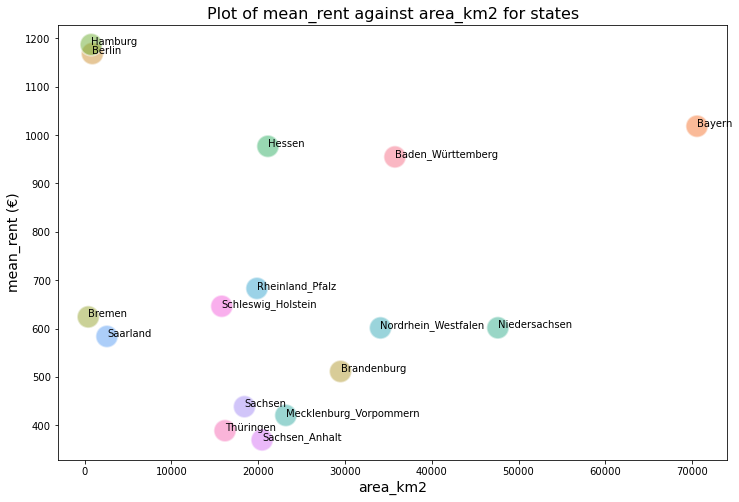

In [28]:
geo_economic_plot(geo_economic, 'state', 'area_km2', 'mean_rent')

- We note that Hamburg and Berlin form a unique cluster with low land mass and high rents. 
- Hess, Baden_Wurttenberg and Bayern also form a cluster with moderately high rent, although Bayern has a high rent in spite of a large land mass.
- The other states form a cluster where it is not clear that rent correlates with area. 

### 5.3.2.2 Rent versus population

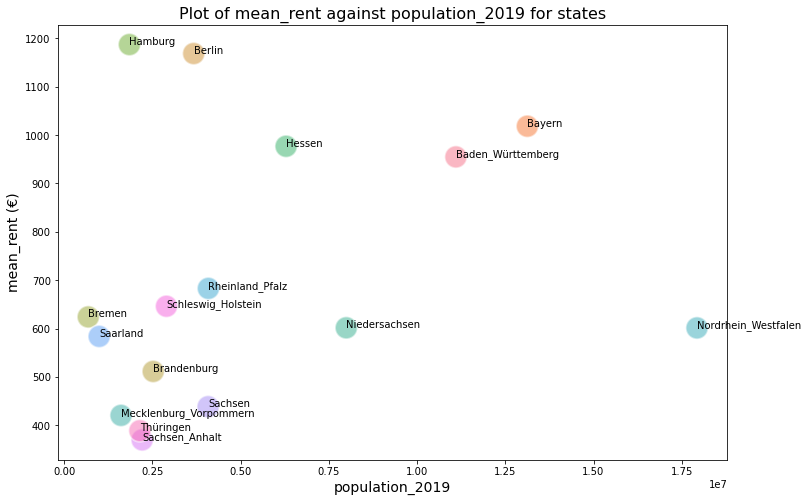

In [29]:
geo_economic_plot(geo_economic, 'state', 'population_2019', 'mean_rent')

- We note the same clusters for rent versus population as we did rent versus land mass and we note that Nordhein Westfalen has the highest population in germany.

### 5.3.2.2 Rent Versus gdp per capita

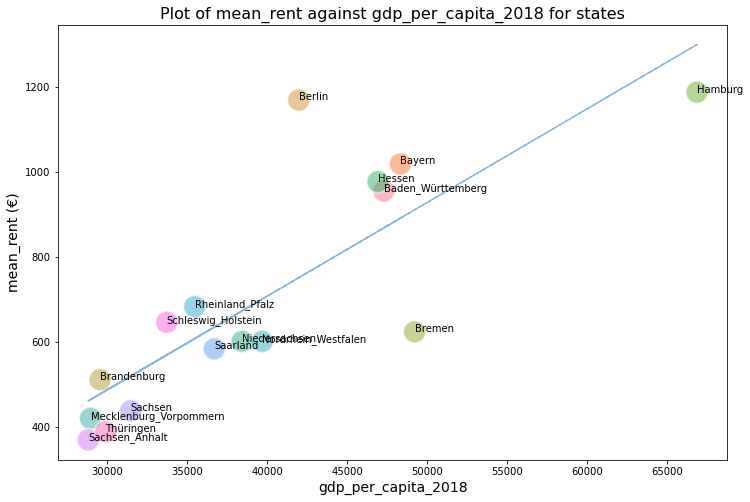

In [30]:
geo_economic_plot(geo_economic, 'state', 'gdp_per_capita_2018', 'mean_rent')
m, b = np.polyfit(geo_economic.gdp_per_capita_2018, geo_economic.mean_rent, 1)
plt.plot(geo_economic.gdp_per_capita_2018, m * geo_economic.gdp_per_capita_2018 + b, alpha = 0.5, ls = '--');

- There seems to be a positive association of rent with gdp per capita. We also observe that Berlin has a comparable mean rent to Hamburg even though Hamburg has a higher gdp per capita. 

### 5.3.2.3 Rent versus hdi

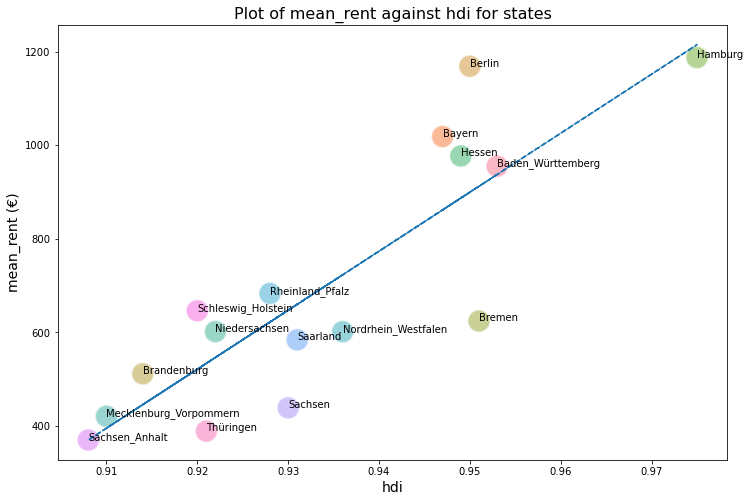

In [31]:
geo_economic_plot(geo_economic, 'state', 'hdi', 'mean_rent')
m, b = np.polyfit(geo_economic.hdi, geo_economic.mean_rent, 1)
plt.plot(geo_economic.hdi, m * geo_economic.hdi + b, ls = '--');

- We see the same trend of rent being positively correlated with hdi as gdp_per_capita.

## 5.3.3 Merging all dataframes

In [32]:
#Merge dataframes and drop unwanted columns
rentals_df = pd.merge(rentals_eda, geo_economic, on = 'state', how = 'inner').drop(columns = ['median_rent', 'mean_rent'])
rentals_df.head()

,state,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,telekomUploadSpeed,yearConstructed,firingTypes,hasKitchen,...,thermalChar,numberOfFloors,garden,date,rent_per_sqm,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi
0,Nordrhein_Westfalen,245.0,central_heating,ONE_YEAR_FREE,False,False,10.0,1965-01-01,oil,False,...,181.4,3.0,True,2019-05-01,6.918605,34085,17932651,526,39678,0.936
1,Nordrhein_Westfalen,95.0,self_contained_central_heating,ONE_YEAR_FREE,False,False,40.0,1953-01-01,gas,False,...,207.7,5.0,False,2019-10-01,5.000000,34085,17932651,526,39678,0.936
2,Nordrhein_Westfalen,200.0,central_heating,ONE_YEAR_FREE,False,False,40.0,1951-01-01,oil,False,...,NaN,4.0,False,2019-10-01,7.696047,34085,17932651,526,39678,0.936
3,Nordrhein_Westfalen,215.0,gas_heating,ONE_YEAR_FREE,True,True,2.4,2018-01-01,gas,False,...,NaN,4.0,False,2019-05-01,11.179310,34085,17932651,526,39678,0.936
4,Nordrhein_Westfalen,121.0,central_heating,ONE_YEAR_FREE,False,True,40.0,1914-01-01,gas,False,...,191.3,4.0,False,2019-05-01,5.061538,34085,17932651,526,39678,0.936


In [33]:
rentals_df = pd.merge(rentals_df, state_supply, on = 'state', how = 'inner').drop(columns = ['median_rent', 'mean_rent'])
rentals_df.head()

,state,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,telekomUploadSpeed,yearConstructed,firingTypes,hasKitchen,...,garden,date,rent_per_sqm,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi,total_state_listings,total_state_sqm
0,Nordrhein_Westfalen,245.0,central_heating,ONE_YEAR_FREE,False,False,10.0,1965-01-01,oil,False,...,True,2019-05-01,6.918605,34085,17932651,526,39678,0.936,62069,4615660.71
1,Nordrhein_Westfalen,95.0,self_contained_central_heating,ONE_YEAR_FREE,False,False,40.0,1953-01-01,gas,False,...,False,2019-10-01,5.000000,34085,17932651,526,39678,0.936,62069,4615660.71
2,Nordrhein_Westfalen,200.0,central_heating,ONE_YEAR_FREE,False,False,40.0,1951-01-01,oil,False,...,False,2019-10-01,7.696047,34085,17932651,526,39678,0.936,62069,4615660.71
3,Nordrhein_Westfalen,215.0,gas_heating,ONE_YEAR_FREE,True,True,2.4,2018-01-01,gas,False,...,False,2019-05-01,11.179310,34085,17932651,526,39678,0.936,62069,4615660.71
4,Nordrhein_Westfalen,121.0,central_heating,ONE_YEAR_FREE,False,True,40.0,1914-01-01,gas,False,...,False,2019-05-01,5.061538,34085,17932651,526,39678,0.936,62069,4615660.71


In [34]:
rentals_df.shape

(266220, 31)

In [35]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266220 entries, 0 to 266219
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   state                 266220 non-null  object 
 1   serviceCharge         259490 non-null  float64
 2   heatingType           221782 non-null  object 
 3   telekomTvOffer        233938 non-null  object 
 4   newlyConst            266220 non-null  bool   
 5   balcony               266220 non-null  bool   
 6   telekomUploadSpeed    233208 non-null  float64
 7   yearConstructed       209427 non-null  object 
 8   firingTypes           209806 non-null  object 
 9   hasKitchen            266220 non-null  bool   
 10  cellar                266220 non-null  bool   
 11  rent                  266220 non-null  float64
 12  livingSpace           266220 non-null  float64
 13  condition             198023 non-null  object 
 14  interiorQual          154634 non-null  object 
 15  

In [36]:
#Convert date information to date time
rentals_df.date = pd.to_datetime(rentals_df.date)
rentals_df.yearConstructed = pd.to_datetime(rentals_df.yearConstructed)

In [37]:
rentals_df[['date', 'yearConstructed']].head()

,date,yearConstructed
0,2019-05-01,1965-01-01
1,2019-10-01,1953-01-01
2,2019-10-01,1951-01-01
3,2019-05-01,2018-01-01
4,2019-05-01,1914-01-01


## 5.3.4 Creating additional features 

In [38]:
rentals_df['listings_per_1000capita'] = (rentals_df.total_state_listings /rentals_df.population_2019) * 1000
rentals_df['listings_per_100sqm'] = (rentals_df.total_state_listings / rentals_df.total_state_sqm) * 100

In [39]:
rentals_df[['listings_per_1000capita', 'listings_per_100sqm']].head()

,listings_per_1000capita,listings_per_100sqm
0,3.461228,1.344748
1,3.461228,1.344748
2,3.461228,1.344748
3,3.461228,1.344748
4,3.461228,1.344748


## 5.4 Variation of rent with time

In [40]:
#Create dataframe with a datetime index
rentals_date = rentals_df.set_index('date')
rentals_date.index

DatetimeIndex(['2019-05-01', '2019-10-01', '2019-10-01', '2019-05-01',
               '2019-05-01', '2018-09-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2020-02-01',
               ...
               '2019-05-01', '2020-02-01', '2019-05-01', '2019-10-01',
               '2020-02-01', '2019-05-01', '2019-05-01', '2020-02-01',
               '2019-05-01', '2020-02-01'],
              dtype='datetime64[ns]', name='date', length=266220, freq=None)

In [41]:
#Create dateframe of rent per state that is resampled by the year
resampled_df = rentals_date.groupby('state')[['rent']].resample('Y').mean()
resampled_df.head()

rent
state             date                   
Baden_Württemberg 2018-12-31   988.657223
                  2019-12-31   940.242491
                  2020-12-31   963.615334
Bayern            2018-12-31  1051.382369
                  2019-12-31  1007.045071

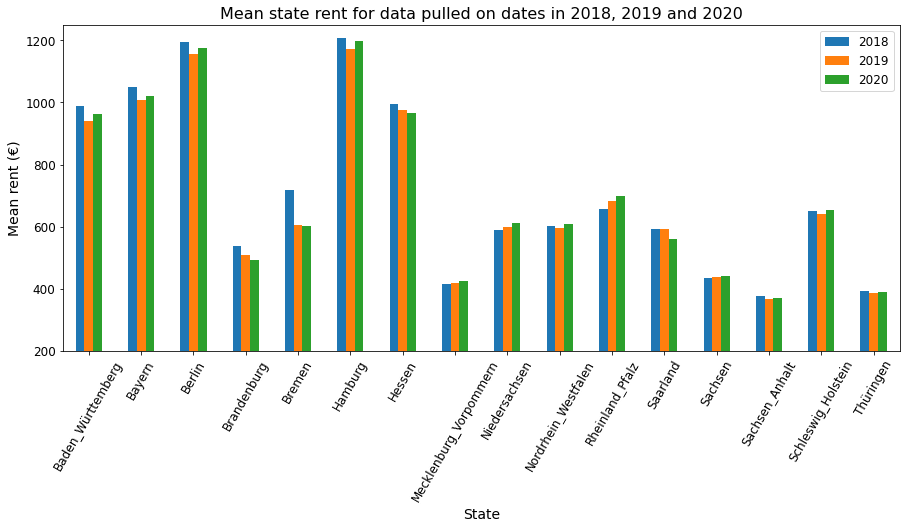

In [42]:
resampled_df.unstack(level=1).plot(kind='bar', figsize = (15,6))
plt.xlabel('State', fontsize = 14)
plt.ylabel('Mean rent (€)', fontsize = 14)
plt.title('Mean state rent for data pulled on dates in 2018, 2019 and 2020', fontsize = 16)
plt.ylim([200,1250])
plt.yticks([200, 400, 600, 800, 1000, 1200])
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 60)
L = plt.legend(loc="upper right", prop = {'size': 12})
L.get_texts()[0].set_text('2018')
L.get_texts()[1].set_text('2019')
L.get_texts()[2].set_text('2020')

- Rents decreased between 2018 and 2019 before rising again in 2020 for half of the states. Note that 2020 data was acquired before COVID19 was wide-spread.

## 5.5 Relationship between rent and advertized features 

In [43]:
#View columns
rentals_df.columns

Index(['state', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'newlyConst',
       'balcony', 'telekomUploadSpeed', 'yearConstructed', 'firingTypes',
       'hasKitchen', 'cellar', 'rent', 'livingSpace', 'condition',
       'interiorQual', 'petsAllowed', 'lift', 'typeOfFlat', 'noRooms',
       'thermalChar', 'numberOfFloors', 'garden', 'date', 'rent_per_sqm',
       'area_km2', 'population_2019', 'population_per_km2',
       'gdp_per_capita_2018', 'hdi', 'total_state_listings', 'total_state_sqm',
       'listings_per_1000capita', 'listings_per_100sqm'],
      dtype='object')

In [44]:
#Review the relationship between heating type and median / mean rent
heatingType = rentals_df.groupby('heatingType').agg(median_rent = pd.NamedAgg(column = 'rent', aggfunc = 'median'), \
                                mean_rent = pd.NamedAgg(column = 'rent', aggfunc = 'mean'))

In [45]:
def plot_feature(df, figsize_row = 10, figsize_col = 6):
    df.sort_values(by = 'median_rent', ascending = False).plot(kind= 'barh', \
                                                               figsize = (figsize_row, figsize_col), fontsize = 12)
    plt.xlabel('Rent (€)', fontsize = 14)
    plt.ylabel(f'{df.index.name}', fontsize = 14)
    plt.title(f'Median and mean rent for {df.index.name}', fontsize = 16)
    plt.legend(loc="upper center",prop = {'size': 12}, bbox_to_anchor=(1.2, 1))
    plt.show;    

In [46]:
def feature_avgs(df, feature):
    new_df = df.groupby(feature).agg(median_rent = pd.NamedAgg(column = 'rent', aggfunc = 'median'), \
                                mean_rent = pd.NamedAgg(column = 'rent', aggfunc = 'mean'))
    return new_df
    

In [47]:
def plot_boxplot(df, feature, target = 'rent', figsize_row = 10, figsize_col = 6):
    plt.subplots(figsize = (figsize_row, figsize_col))
    sns.boxplot(x= target, y= feature, width = 0.8, data= df)
    plt.title(f'Plot of {feature} versus Rent (€)', fontsize = 16)
    plt.xlabel('Rent (€)', fontsize = 14)
    plt.ylabel(feature, fontsize = 14)
    plt.show;

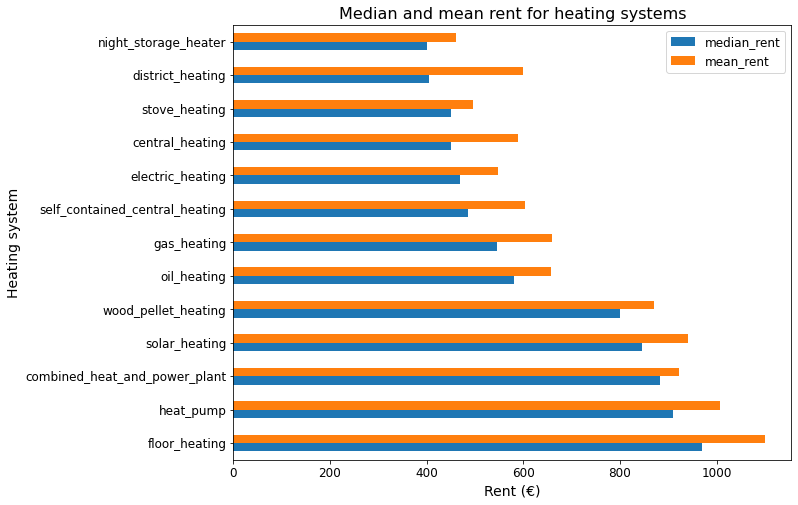

In [48]:
heatingType.sort_values(by = 'median_rent', ascending = False).plot(kind= 'barh', figsize = (10, 8), fontsize = 12)
plt.xlabel('Rent (€)', fontsize = 14)
plt.ylabel('Heating system', fontsize = 14)
plt.title('Median and mean rent for heating systems', fontsize = 16)
L=plt.legend(prop = {'size': 12})
plt.show;

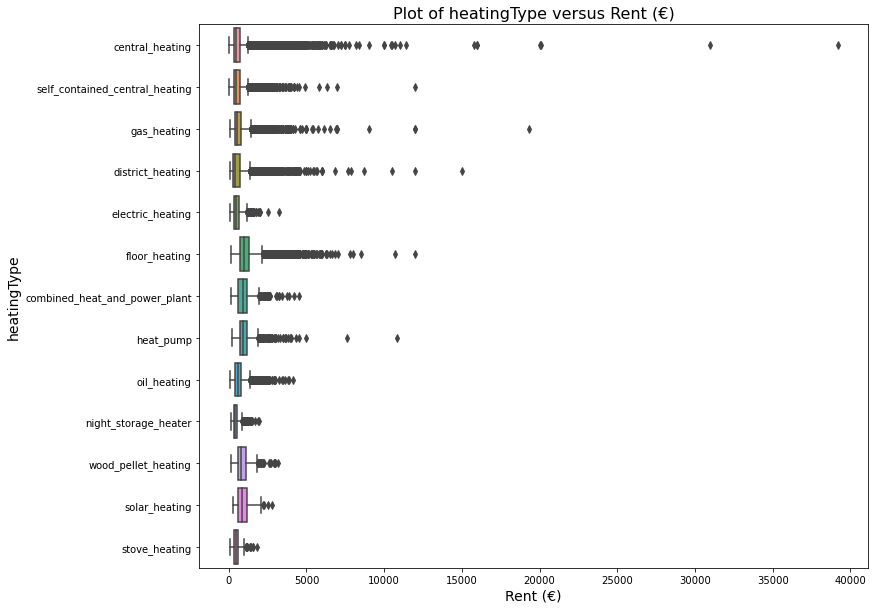

In [49]:
plot_boxplot(rentals_df, feature = 'heatingType', figsize_row = 12, figsize_col = 10)

- A CHP plant, heat pump and floor heating system commnad the highest rents.
- Night storage heating, district heating and stove heating command the lowest rents.

In [50]:
def rentals_ANOVA(df, predictor_feature, target_feature = 'rent'):
    model = ols(f'{target_feature} ~ {predictor_feature}', data = df).fit()
    anova_table = sm.stats.anova_lm(model,  type = 2)
    return anova_table
    

In [51]:
rentals_ANOVA(rentals_df,'heatingType' )

,df,sum_sq,mean_sq,F,PR(>F)
heatingType,12.0,4.756839e+09,3.964033e+08,1664.563386,0.0
Residual,221769.0,5.281262e+10,2.381425e+05,NaN,NaN


In [52]:
#tvOffer
tvOffer = rentals_df.groupby('telekomTvOffer').agg(median_rent = pd.NamedAgg(column = 'rent', aggfunc = 'median'), \
                                mean_rent = pd.NamedAgg(column = 'rent', aggfunc = 'mean'))
tvOffer

,median_rent,mean_rent
telekomTvOffer,,
NONE,460.0,555.902282
ONE_YEAR_FREE,475.0,631.986259
ON_DEMAND,440.0,583.835698


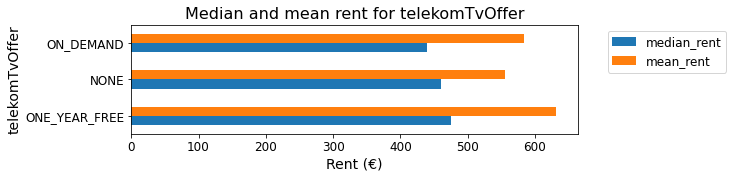

In [53]:
plot_feature(tvOffer, 8, 2)

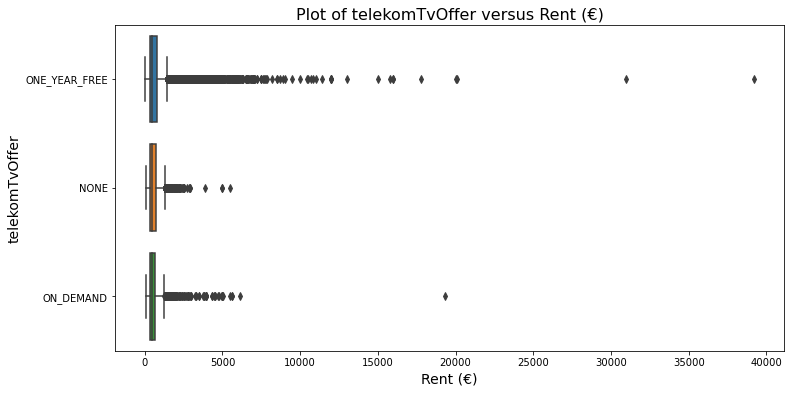

In [54]:
plot_boxplot(rentals_df, feature = 'telekomTvOffer', figsize_row = 12, figsize_col = 6)

In [55]:
rentals_ANOVA(rentals_df,'telekomTvOffer' )

,df,sum_sq,mean_sq,F,PR(>F)
telekomTvOffer,2.0,3.543854e+07,1.771927e+07,68.069246,2.795765e-30
Residual,233935.0,6.089618e+10,2.603124e+05,NaN,NaN


- Rent seems to be higher for units that include one year free tv

In [56]:
newlyconst = feature_avgs(rentals_df, 'newlyConst')

In [57]:
newlyconst

,median_rent,mean_rent
newlyConst,,
False,460.0,610.696818
True,980.0,1098.259420


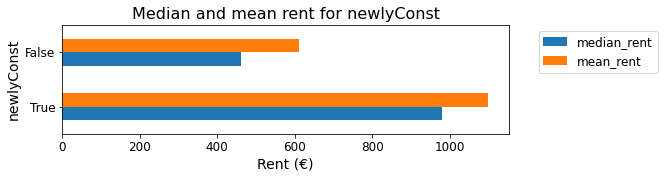

In [58]:
plot_feature(newlyconst, 8, 2)

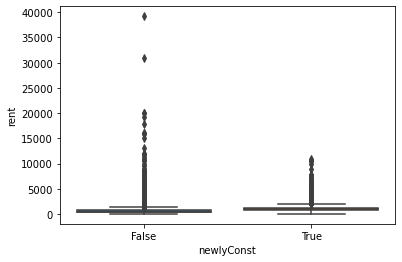

In [59]:
sns.boxplot(x = rentals_df.newlyConst, y = rentals_df.rent);

In [60]:
rentals_ANOVA(rentals_df,'newlyConst' )

,df,sum_sq,mean_sq,F,PR(>F)
newlyConst,1.0,4.593673e+09,4.593673e+09,18383.25501,0.0
Residual,266218.0,6.652350e+10,2.498836e+05,NaN,NaN


- Rents seem to be higher for units in newly constructed buildings

In [61]:
balcony = feature_avgs(rentals_df, 'balcony')
balcony

,median_rent,mean_rent
balcony,,
False,390.0,494.526356
True,595.0,744.955362


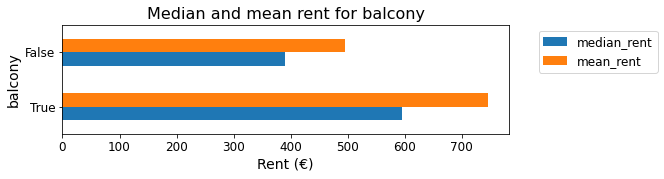

In [62]:
plot_feature(balcony, 8, 2)

In [63]:
rentals_ANOVA(rentals_df,'balcony' )

,df,sum_sq,mean_sq,F,PR(>F)
balcony,1.0,3.944276e+09,3.944276e+09,15631.858297,0.0
Residual,266218.0,6.717290e+10,2.523229e+05,NaN,NaN


- Rent seems to be higher for those units with a balcony

In [64]:
firingTypes = feature_avgs(rentals_df, 'firingTypes')
firingTypes

,median_rent,mean_rent
firingTypes,,
bio_energy,895.000,1126.397407
coal,319.000,544.687692
coal_coke,590.000,705.400000
combined_heat_and_power_bio_energy,560.000,786.461538
combined_heat_and_power_fossil_fuels,830.000,988.426394
combined_heat_and_power_regenerative_energy,974.440,1092.786979
combined_heat_and_power_renewable_energy,995.000,1154.591061
district_heating,413.640,631.538534
electricity,520.000,649.709755


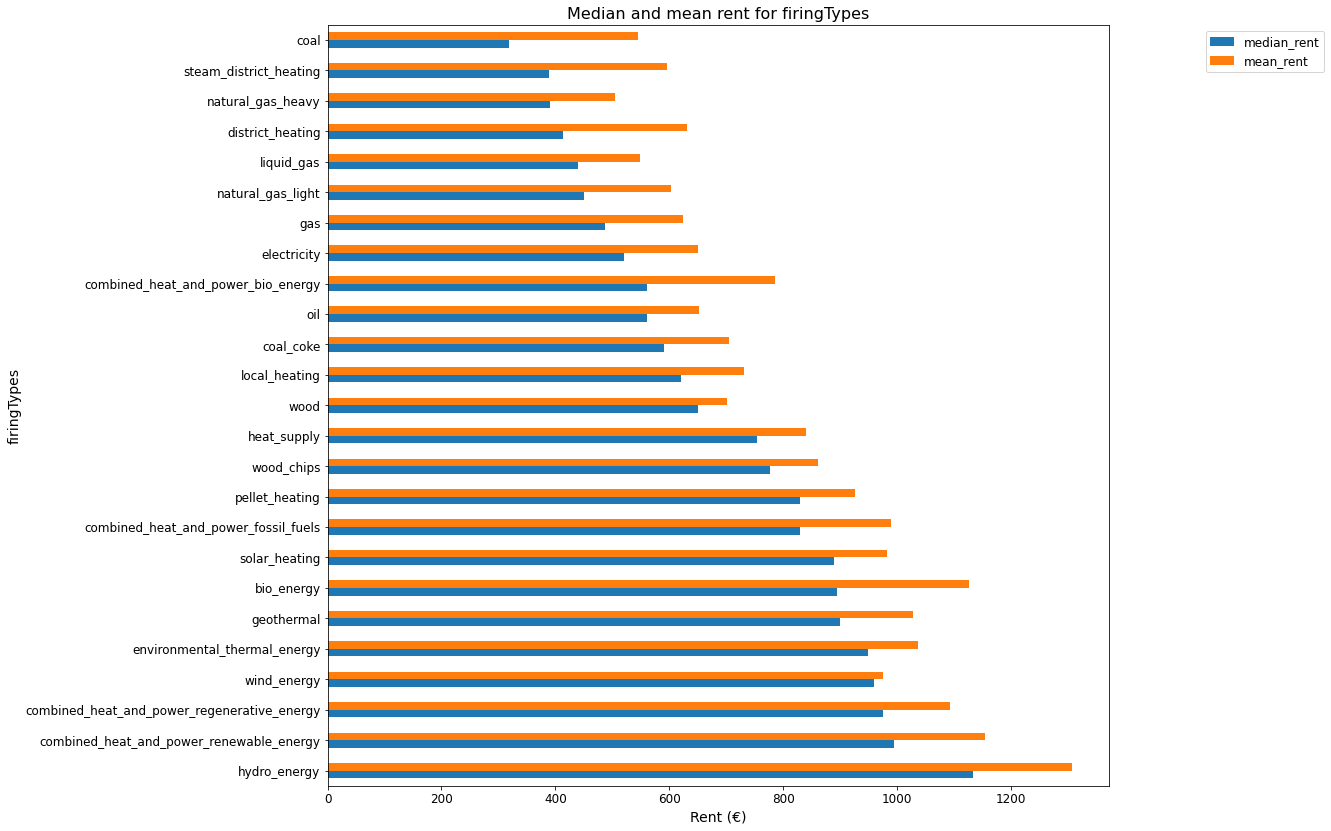

In [65]:
plot_feature(firingTypes, 14, 14)

In [66]:
rentals_ANOVA(rentals_df,'firingTypes' )

,df,sum_sq,mean_sq,F,PR(>F)
firingTypes,24.0,1.237501e+09,5.156256e+07,209.021132,0.0
Residual,209781.0,5.175001e+10,2.466859e+05,NaN,NaN


- We note that heavy natural gas and coal fired units have lower rents compared to units that use renewable energy sources (i.e. hydro_energy, combined_heat_and_power_renewable_energy, bio_energy, etc.)

In [67]:
yearConstructed = rentals_df.groupby('yearConstructed')[['rent']].mean()
yearConstructed.tail()

,rent
yearConstructed,
2019-01-01,1112.119745
2020-01-01,994.921871
2021-01-01,1042.880000
2022-01-01,661.500000
2026-01-01,2000.000000


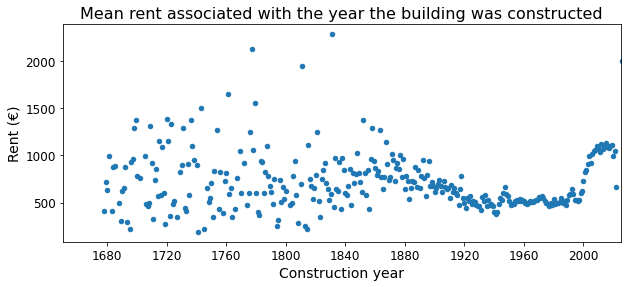

In [68]:
yearConstructed.reset_index().plot(x = 'yearConstructed', y = 'rent', kind = 'scatter', figsize = (10, 4))
plt.title('Mean rent associated with the year the building was constructed', fontsize = 16)
plt.xlabel('Construction year', fontsize =14)
plt.ylabel('Rent (€)', fontsize = 14)
start = datetime.strptime('1650', '%Y')
end = datetime.strptime('2025', '%Y')
plt.xlim([start, end])
plt.tick_params(labelsize = 12);

<AxesSubplot:xlabel='yearConstructed', ylabel='rent'>

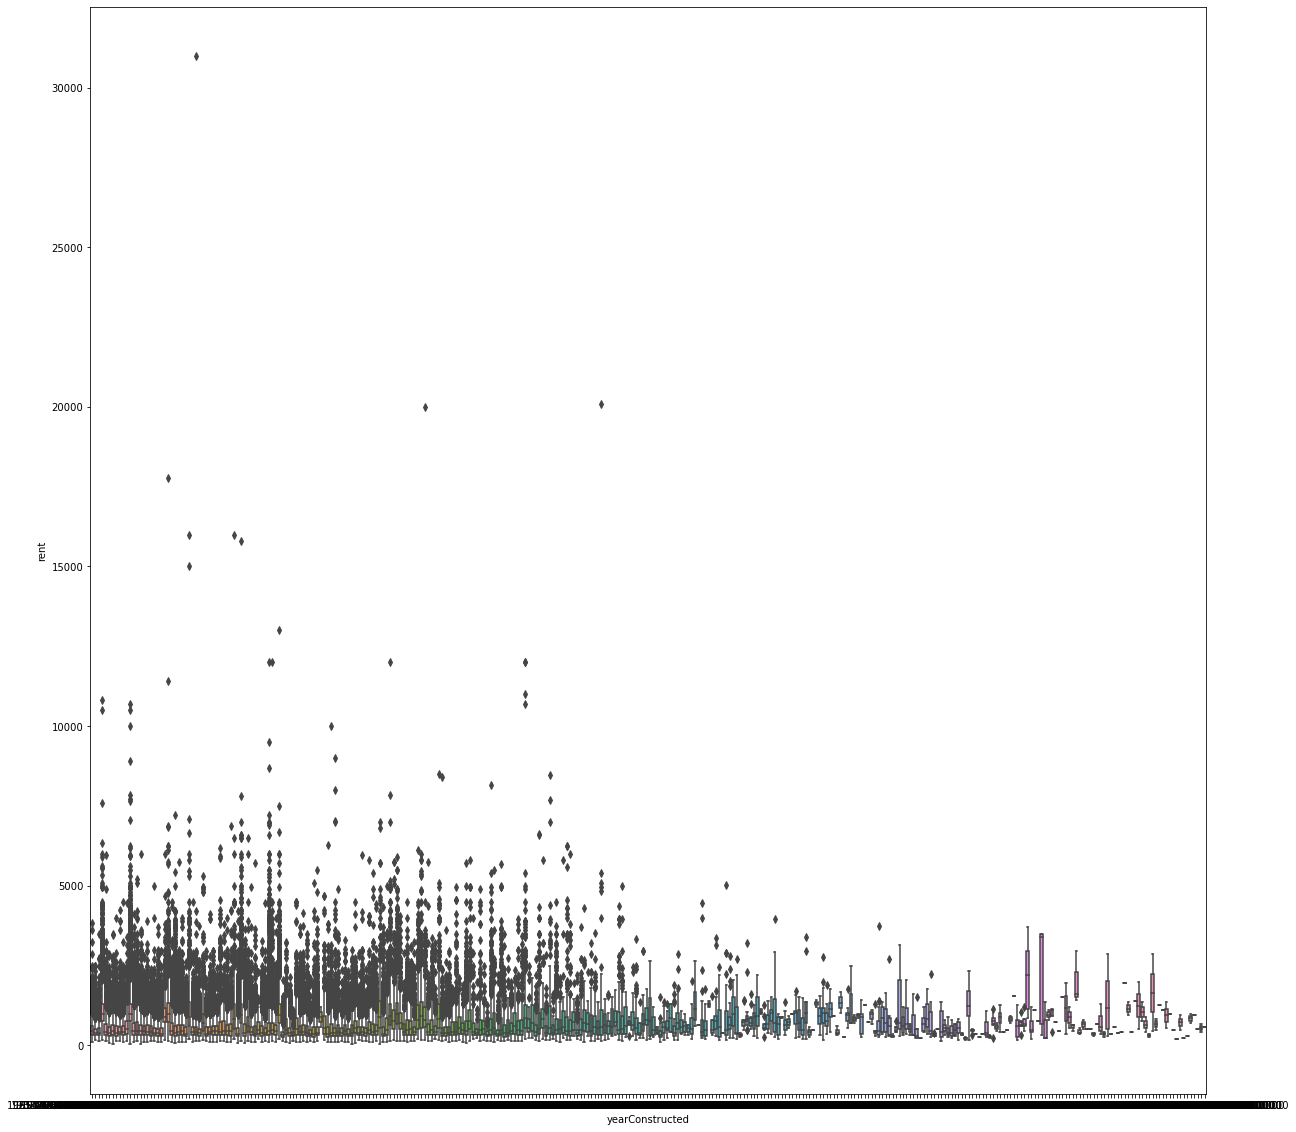

In [71]:
plt.subplots(figsize = (20,20))
sns.boxplot(x = rentals_df.yearConstructed, y = rentals_df.rent)

In [69]:
rentals_ANOVA(rentals_df,'yearConstructed' )

,df,sum_sq,mean_sq,F,PR(>F)
yearConstructed,322.0,1.064324e+10,3.305354e+07,145.332657,0.0
Residual,265897.0,6.047393e+10,2.274337e+05,NaN,NaN


- There is no clear association between year constructed an rent. This is counter intuitive because one would expect new units to fetch higher rent. 

In [70]:
#Review the relationship between the availability of a kitchen and mean rent
hasKitchen = feature_avgs(rentals_df, 'hasKitchen')
hasKitchen

,median_rent,mean_rent
hasKitchen,,
False,423.86,551.964657
True,685.00,835.072058


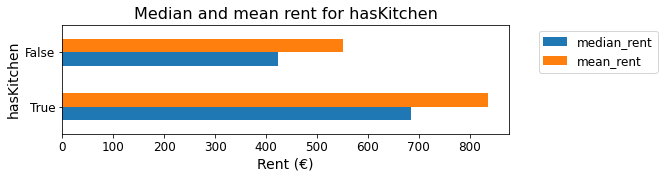

In [71]:
plot_feature(hasKitchen, 8, 2)

In [72]:
rentals_ANOVA(rentals_df,'hasKitchen' )

,df,sum_sq,mean_sq,F,PR(>F)
hasKitchen,1.0,4.809467e+09,4.809467e+09,19309.471563,0.0
Residual,266218.0,6.630771e+10,2.490730e+05,NaN,NaN


- Units with a kitchen seem to fetch higher rents.

In [73]:
cellar = feature_avgs(rentals_df, 'cellar')
cellar

,median_rent,mean_rent
cellar,,
False,490.0,637.400701
True,495.0,655.663562


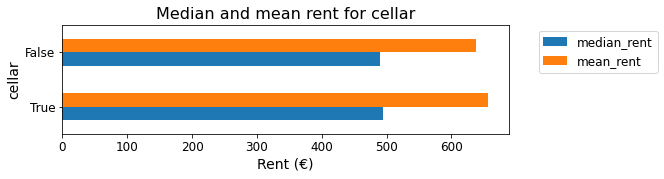

In [74]:
plot_feature(cellar, 8, 2)

In [75]:
rentals_ANOVA(rentals_df,'cellar' )

,df,sum_sq,mean_sq,F,PR(>F)
cellar,1.0,2.042267e+07,2.042267e+07,76.471603,2.246645e-18
Residual,266218.0,7.109675e+10,2.670621e+05,NaN,NaN


- There is no clear advantage to having a cellar in terms on its effect on rent.

In [76]:
#Review the relationship between the condition of the unit and mean rent
condition = feature_avgs(rentals_df, 'condition')
condition

,median_rent,mean_rent
condition,,
first_time_use,980.00,1091.743858
first_time_use_after_refurbishment,650.00,781.157043
fully_renovated,446.25,584.506154
mint_condition,820.00,975.362555
modernized,468.68,575.820103
negotiable,382.50,484.883230
refurbished,370.00,495.044416
well_kept,450.00,547.339416


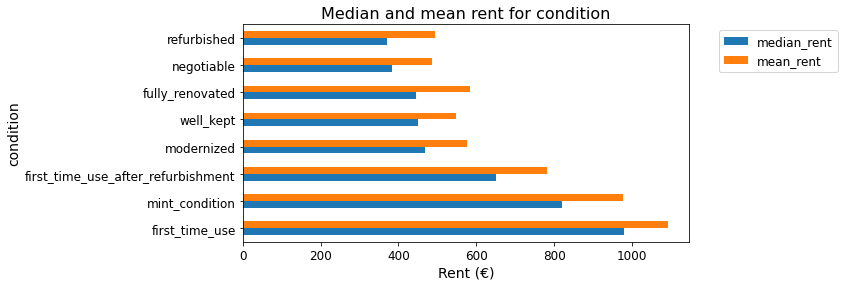

In [77]:
plot_feature(condition, 8, 4)

In [78]:
rentals_ANOVA(rentals_df,'condition' )

,df,sum_sq,mean_sq,F,PR(>F)
condition,7.0,8.339183e+09,1.191312e+09,5192.299917,0.0
Residual,198015.0,4.543220e+10,2.294382e+05,NaN,NaN


- First time use rental units appear to fetch the highest rents

In [79]:
#Review the relationship between interior quality of the apartment and mean rent
interiorQual = feature_avgs(rentals_df, 'interiorQual')
interiorQual

,median_rent,mean_rent
interiorQual,,
luxury,1300.0,1592.847991
normal,395.0,466.623974
simple,360.0,421.761748
sophisticated,790.0,885.284553


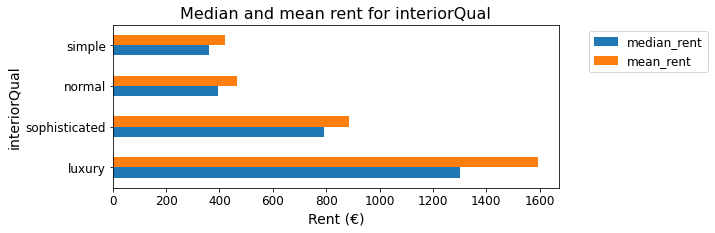

In [80]:
plot_feature(interiorQual, 8, 3)

In [81]:
rentals_ANOVA(rentals_df,'interiorQual' )

,df,sum_sq,mean_sq,F,PR(>F)
interiorQual,3.0,1.280370e+10,4.267899e+09,20746.677086,0.0
Residual,154630.0,3.180968e+10,2.057148e+05,NaN,NaN


- Luxury and sophisticated units appear to fetch higher rents

In [82]:
#Review the relationship between whether pets are allowed and mean rent
petsAllowed = feature_avgs(rentals_df, 'petsAllowed')
petsAllowed

,median_rent,mean_rent
petsAllowed,,
negotiable,449.0,607.845316
no,650.0,742.689649
yes,430.0,621.131208


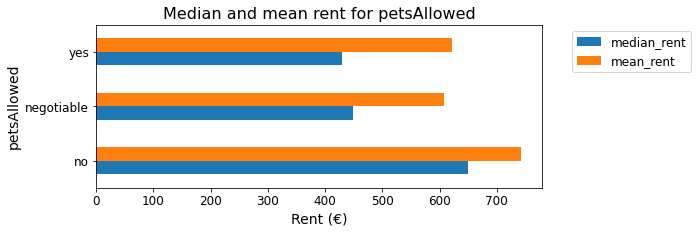

In [83]:
plot_feature(petsAllowed, 8, 3)

In [84]:
rentals_ANOVA(rentals_df,'petsAllowed' )

,df,sum_sq,mean_sq,F,PR(>F)
petsAllowed,2.0,6.104503e+08,3.052252e+08,1314.828043,0.0
Residual,152722.0,3.545300e+10,2.321407e+05,NaN,NaN


- Units that don't allow pets seem to be more expensive than those who allow pets

In [85]:
#Review the relationship between whether the apartment has a lift and mean rent
lift = feature_avgs(rentals_df, 'lift')
lift

,median_rent,mean_rent
lift,,
False,445.0,564.863018
True,775.0,922.088524


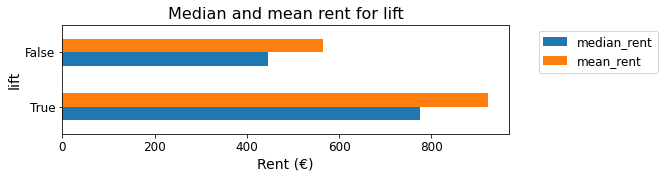

In [86]:
plot_feature(lift, 8, 2)

In [87]:
rentals_ANOVA(rentals_df,'lift' )

,df,sum_sq,mean_sq,F,PR(>F)
lift,1.0,6.122660e+09,6.122660e+09,25078.460883,0.0
Residual,266218.0,6.499451e+10,2.441402e+05,NaN,NaN


- Units that have a lift seem to be more expensive than those without

In [88]:
#Review the relationship between the type of flat and mean rent
typeOfFlat = feature_avgs(rentals_df, 'typeOfFlat')
typeOfFlat

,median_rent,mean_rent
typeOfFlat,,
apartment,480.0,626.268103
ground_floor,500.0,619.433687
half_basement,478.5,537.332330
loft,1000.0,1217.335611
maisonette,900.0,1057.690589
other,480.0,618.904145
penthouse,1350.0,1558.706953
raised_ground_floor,490.0,604.151214
roof_storey,480.0,607.438714


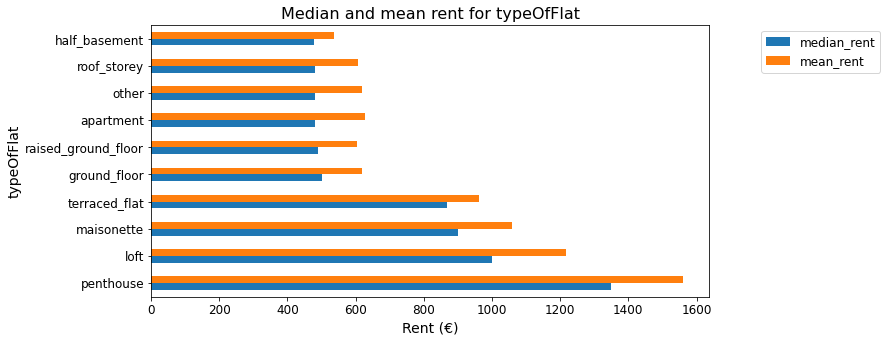

In [89]:
plot_feature(typeOfFlat, 10, 5)

In [90]:
rentals_ANOVA(rentals_df,'typeOfFlat' )

,df,sum_sq,mean_sq,F,PR(>F)
typeOfFlat,9.0,5.290428e+09,5.878253e+08,2444.274494,0.0
Residual,229887.0,5.528569e+10,2.404907e+05,NaN,NaN


- penthouse's, loft's and maisonette's seem to fetch higher rents than other rental unit styles

In [91]:
noRooms = feature_avgs(rentals_df, 'noRooms')
noRooms.head()

,median_rent,mean_rent
noRooms,,
1.00,305.0,380.301783
1.10,320.0,365.112000
1.20,355.0,355.000000
1.25,450.0,450.000000
1.30,390.0,390.000000


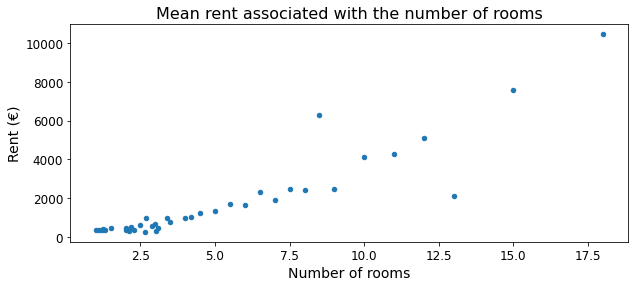

In [92]:
noRooms.reset_index().plot(x = 'noRooms', y = 'mean_rent', kind = 'scatter', figsize = (10, 4))
plt.title('Mean rent associated with the number of rooms', fontsize = 16)
plt.xlabel('Number of rooms', fontsize =14)
plt.ylabel('Rent (€)', fontsize = 14)
plt.tick_params(labelsize = 12);

In [93]:
rentals_ANOVA(rentals_df,'noRooms' )

,df,sum_sq,mean_sq,F,PR(>F)
noRooms,1.0,1.382550e+10,1.382550e+10,64243.119148,0.0
Residual,266218.0,5.729168e+10,2.152059e+05,NaN,NaN


 - As the number of rooms increase the rent seems to increase

In [94]:
rentals_ANOVA(rentals_df,'rent_per_sqm' )

,df,sum_sq,mean_sq,F,PR(>F)
rent_per_sqm,1.0,2.659129e+10,2.659129e+10,158987.944909,0.0
Residual,266218.0,4.452589e+10,1.672535e+05,NaN,NaN


In [95]:
rentals_df.head()

,state,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,telekomUploadSpeed,yearConstructed,firingTypes,hasKitchen,...,rent_per_sqm,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi,total_state_listings,total_state_sqm,listings_per_1000capita,listings_per_100sqm
0,Nordrhein_Westfalen,245.0,central_heating,ONE_YEAR_FREE,False,False,10.0,1965-01-01,oil,False,...,6.918605,34085,17932651,526,39678,0.936,62069,4615660.71,3.461228,1.344748
1,Nordrhein_Westfalen,95.0,self_contained_central_heating,ONE_YEAR_FREE,False,False,40.0,1953-01-01,gas,False,...,5.000000,34085,17932651,526,39678,0.936,62069,4615660.71,3.461228,1.344748
2,Nordrhein_Westfalen,200.0,central_heating,ONE_YEAR_FREE,False,False,40.0,1951-01-01,oil,False,...,7.696047,34085,17932651,526,39678,0.936,62069,4615660.71,3.461228,1.344748
3,Nordrhein_Westfalen,215.0,gas_heating,ONE_YEAR_FREE,True,True,2.4,2018-01-01,gas,False,...,11.179310,34085,17932651,526,39678,0.936,62069,4615660.71,3.461228,1.344748
4,Nordrhein_Westfalen,121.0,central_heating,ONE_YEAR_FREE,False,True,40.0,1914-01-01,gas,False,...,5.061538,34085,17932651,526,39678,0.936,62069,4615660.71,3.461228,1.344748


# 6. Summary 

- There are appears to be three groups of states that have similar their rent behavior. These include the high-rent states of Berlin and Hamburg, the moderate-rent states of Hessen, Bayern and Baden Wurttenberg, and the low-rent states consisting of the remaining 10 states. 
- Location is a considerable determinant of rent
- We examined features on a state-wide level and established that rent is affected by macro-economic conditions such as the total supply of rental units, population, regional gdp and the human development index.
- There was no clear trend associated to price movements of rent over the three dates when data was accumulated.
- The presence of certain features seemed to correlate with higher rent.

In [96]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266220 entries, 0 to 266219
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   state                    266220 non-null  object        
 1   serviceCharge            259490 non-null  float64       
 2   heatingType              221782 non-null  object        
 3   telekomTvOffer           233938 non-null  object        
 4   newlyConst               266220 non-null  bool          
 5   balcony                  266220 non-null  bool          
 6   telekomUploadSpeed       233208 non-null  float64       
 7   yearConstructed          209427 non-null  datetime64[ns]
 8   firingTypes              209806 non-null  object        
 9   hasKitchen               266220 non-null  bool          
 10  cellar                   266220 non-null  bool          
 11  rent                     266220 non-null  float64       
 12  livingSpace     

# 7. Saving Data

In [99]:
datapath = '..\data\interim'
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [100]:
datapath_rentals = os.path.join(datapath, 'rentals_processing.csv')
if not os.path.exists(datapath_rentals):
    rentals_df.to_csv(datapath_rentals, index=False)